# Graphstorm Standalone Mode Demonstration

In this notebook, we'll demonstrate how to use the standalone mode of Graphstorm. The standalone mode is primarily designed for model developers to prototype their data and model training/evaluation/inference pipelines using a single machine. 

---

## Setup 

This notebook requires installing graphstorm using pip. Please find [more details on installation of graphstorm](https://graphstorm.readthedocs.io/en/latest/install/env-setup.html#setup-graphstorm-with-pip-packages).

In [1]:
# !pip install graphstorm

In [2]:
import os
from argparse import Namespace
import matplotlib.pyplot as plt
# import graphstorm related stuffs
import graphstorm as gs
from graphstorm.config import GSConfig
from graphstorm.trainer import GSgnnNodePredictionTrainer
from graphstorm.dataloading import GSgnnNodeTrainData, GSgnnNodeDataLoader, GSgnnNodeInferData
from graphstorm.inference import GSgnnNodePredictionInferrer
from graphstorm.eval import GSgnnAccEvaluator

In [3]:
# init the graphstorm "cluster"
def init_standalone_environment():
    """Initialize standalone environment for graphstorm"""
    env_vars = {
        'RANK': '0',
        'WORLD_SIZE': '1',
        'MASTER_ADDR': '127.0.0.1',
        'MASTER_PORT': '54321'
    }
    # set up required ENV_VAR for distributed context
    for key, val in env_vars.items():
        os.environ[key] = val

    gs.initialize(ip_config=env_vars['MASTER_ADDR'], backend='gloo')

init_standalone_environment()
device = gs.utils.setup_device(0)

## Develop a GNN model for node-classification 

Next, we use a GNN model to go over the model development cycle of a node classification problem on the MovieLens dataset. 


### 0. Load the constructed graph data

We can use the following codes to set up the `GSConfig` object by providing the yaml config file of the training script and the json config file about the constructed graph dataset. `GSConfig` handles the parsing of all the config files normally provided through command line. Therefore, we can simulate this in the Notebook using `argparse.Namespace`. 

In [4]:
# training config:
yaml_config_file = '../training_scripts/gsgnn_np/ml_nc.yaml'
# constructed graphstorm data config:
constructed_graph_config = '/mnt/efs/gsf-data/movielen_100k_train_val_1p_4t/movie-lens-100k.json'

cmd_args = {
    'yaml_config_file': yaml_config_file,
    'part_config': constructed_graph_config,
    'local_rank': os.environ['RANK'],
}
cmd_args = Namespace(**cmd_args)
config = GSConfig(cmd_args)

In [5]:
# load the constructed graph data
train_data = GSgnnNodeTrainData(
    graph_name=config.graph_name,
    part_config=config.part_config,
    train_ntypes=config.target_ntype,
    eval_ntypes=config.target_ntype,
    node_feat_field=config.node_feat_name,
    label_field=config.label_field)

INFO:root:Start to load partition from /mnt/efs/gsf-data/movielen_100k_train_val_1p_4t/part0/graph.dgl which is 5839353 bytes. It may take non-trivial time for large partition.
INFO:root:Finished loading partition.
INFO:root:Finished loading node data.
INFO:root:Finished loading edge data.
INFO:root:part 0, train: 1345, val: 168, test: 168


In [6]:
# train_data.g stores a DistGraph object
print('Number of nodes:')
for ntype in train_data.g.ntypes:
    print(f'- {ntype}: {train_data.g.num_nodes(ntype)}')
print('Number of edges:')
for etype in train_data.g.etypes:
    print(f'- {etype}: {train_data.g.num_edges(etype)}')

Number of nodes:
- movie: 1682
- user: 943
Number of edges:
- rating-rev: 100000
- rating: 100000


In [7]:
# set up data loaders
dataloader = GSgnnNodeDataLoader(
    train_data, train_data.train_idxs, fanout=config.fanout,
    batch_size=config.batch_size,
    device=device, train_task=True)

val_dataloader = GSgnnNodeDataLoader(
    train_data, train_data.val_idxs, fanout=config.fanout,
    batch_size=config.batch_size,
    device=device, train_task=False)

test_dataloader = GSgnnNodeDataLoader(
    train_data, train_data.test_idxs, fanout=config.fanout,
    batch_size=config.batch_size,
    device=device, train_task=False)

### 2. Create a GNN model

Here we use a built-in GNN model from graphstorm. We can see the model is composed of `GSNodeEncoderInputLayer`, `RelationalGCNEncoder`, `EntityClassifier`. One can also replace this with a custom model for development purpose.

In [8]:
# create a built-in gsf model
model = gs.create_builtin_node_gnn_model(
    train_data.g, 
    config, 
    train_task=True)
model

GSgnnNodeModel(
  (_node_input_encoder): GSNodeEncoderInputLayer(
    (dropout): Dropout(p=0.0, inplace=False)
    (proj_matrix): ParameterDict(
        (movie): Parameter containing: [torch.FloatTensor of size 128x128]
        (user): Parameter containing: [torch.FloatTensor of size 128x128]
    )
    (input_projs): ParameterDict()
    (ngnn_mlp): ModuleDict(
      (movie): NGNNMLP(
        (dropout): Dropout(p=0.0, inplace=False)
        (ngnn_gnn): ParameterList()
      )
      (user): NGNNMLP(
        (dropout): Dropout(p=0.0, inplace=False)
        (ngnn_gnn): ParameterList()
      )
    )
  )
  (_gnn_encoder): RelationalGCNEncoder(
    (_layers): ModuleList(
      (0): RelGraphConvLayer(
        (conv): HeteroGraphConv(
          (mods): ModuleDict(
            (('movie', 'rating-rev', 'user')): GraphConv(in=128, out=128, normalization=right, activation=None)
            (('user', 'rating', 'movie')): GraphConv(in=128, out=128, normalization=right, activation=None)
          )
  

In [9]:
num_params = sum(p.numel() for p in model.parameters())
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of model parameters:', num_params)
print('Number of trainable parameters:', num_trainable_params)

Number of model parameters: 84480
Number of trainable parameters: 84480


### 3. Create a graphstorm trainer and train the model
The trainers is task-specific in graphstorm. It handles:
1. model training/evaluation loops
2. saving and restoring model checkpoints
3. early-stopping

In [10]:
# create a trainer for the model
trainer = GSgnnNodePredictionTrainer(
    model, 
    topk_model_to_save=1)

# set up device for the trainer
trainer.setup_device(device=device)

# set up evaluator for the trainer:
evaluator = GSgnnAccEvaluator(
    eval_frequency=config.eval_frequency,
    eval_metric=config.eval_metric,
    multilabel=config.multilabel)
trainer.setup_evaluator(evaluator)


In [11]:
# Train the model with the trainer
trainer.fit(
    train_loader=dataloader, 
    val_loader=val_dataloader,
    test_loader=test_dataloader, 
    num_epochs=10,
    save_model_path='nc_model/',
)

/opt/conda/envs/pytorch/lib/python3.10/site-packages/torch/nn/parallel/distributed.py:1915: UserWarning: You passed find_unused_parameters=true to DistributedDataParallel, `_set_static_graph` will detect unused parameters automatically, so you do not need to set find_unused_parameters=true, just be sure these unused parameters will not change during training loop while calling `_set_static_graph`.
  warnings.warn(
INFO:root:Part 0 | Epoch 00000 | Batch 000 | Loss: 5.0432 | Time: 1.2219
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:root:Epoch 0 take 1.325 seconds
INFO:root:successfully save the model to nc_model/epoch-0
INFO:root:Time on save model: 0.007 seconds
INFO:root:Part 0 | Epoch 00001 | Batch 000 | Loss: 3.1350 | Time: 0.0110
INFO:root:Epoch 1 take 0.110 seconds
INFO:root:successfully save the model to nc_model/epoch-1
INFO:root:Time on save model: 0.006 seconds
INFO:root:Part 0 | Epoch 00002 | Batch 000 | Loss: 2.0955 | Time: 0.01

Next, we examine the model performance over the training process

In [12]:
# Extract accuracies from the trainer's evaluator:
val_accs, test_accs = [], []
for val_acc, test_acc in trainer.evaluator._history:
    val_accs.append(val_acc['accuracy'])
    test_accs.append(test_acc['accuracy'])

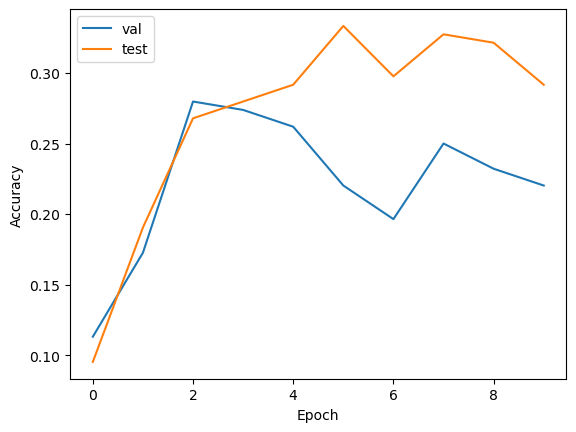

In [13]:
# plot the learning curves
fig, ax = plt.subplots()
ax.plot(val_accs, label='val')
ax.plot(test_accs, label='test')
ax.set(xlabel='Epoch', ylabel='Accuracy')
ax.legend(loc='best');

In [14]:
# after training, the best model is saved to disk:
best_model_path = trainer.get_best_model_path()
print('Best model checkpoint:', best_model_path)

Best model checkpoint: nc_model/epoch-2


In [15]:
# check the saved artifacts
!ls -ls {best_model_path}

total 1012
336 -rw-rw-r-- 1 ubuntu ubuntu 340551 Oct  5 20:46 model.bin
  4 drwxrw-rwx 2 ubuntu ubuntu   4096 Oct  5 20:46 movie
668 -rw-rw-r-- 1 ubuntu ubuntu 681259 Oct  5 20:46 optimizers.bin
  4 drwxrw-rwx 2 ubuntu ubuntu   4096 Oct  5 20:46 user


### 3. Inference with the trained model

In [16]:
# we can restore the model from the checkpoint:
model.restore_model(best_model_path)

/opt/conda/envs/pytorch/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
INFO:root:successfully load the model from nc_model/epoch-2
INFO:root:Time on load model: 0.010 seconds


In [17]:
# Create a dataset for inference, we use the same MovieLens graph
infer_data = GSgnnNodeInferData(
    config.graph_name, 
    config.part_config,
    eval_ntypes=config.target_ntype,
    node_feat_field=config.node_feat_name,
    label_field=config.label_field)

# Set up dataloader for the inference dataset
infer_dataloader = GSgnnNodeDataLoader(
    infer_data, infer_data.test_idxs, fanout=config.fanout, 
    batch_size=100, device=device,
    train_task=False)


# Create an Inferrer object
infer = GSgnnNodePredictionInferrer(model)
infer.setup_device(device=device)
infer.setup_evaluator(evaluator)


INFO:root:Start to load partition from /mnt/efs/gsf-data/movielen_100k_train_val_1p_4t/part0/graph.dgl which is 5839353 bytes. It may take non-trivial time for large partition.
INFO:root:Finished loading partition.
INFO:root:Finished loading node data.
INFO:root:Finished loading edge data.


In [18]:
# Run inference on the inference dataset
infer.infer(infer_dataloader, 
            save_embed_path=os.path.join(best_model_path, 'infer/embeddings'),
            save_prediction_path=os.path.join(best_model_path, 'infer/predictions'),
            use_mini_batch_infer=True)

INFO:root:Writing GNN embeddings to nc_model/epoch-2/infer/embeddings in pytorch format.


In [19]:
# The GNN embeddings on the inference graph are saved to:
!ls -lh {best_model_path}/infer/embeddings

total 848K
-rw-rw-r-- 1 ubuntu ubuntu   40 Oct  5 20:47 emb_info.json
-rw-rw-r-- 1 ubuntu ubuntu 842K Oct  5 20:47 movie_emb.part00000.bin


In [20]:
!ls -lh {best_model_path}/infer/predictions

total 16K
-rw-rw-r-- 1 ubuntu ubuntu 14K Oct  5 20:47 predict-00000.pt
